In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set paths to your directories
train_dir = r"C:\Users\Sameer Ahmad\Desktop\New_retinal_non_retinal\retinal_binary_classifier_dataset\train"
val_dir = r"C:\Users\Sameer Ahmad\Desktop\New_retinal_non_retinal\retinal_binary_classifier_dataset\val"

# Create ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=20)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  # Binary classification (retinal vs non-retinal)
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
)


Found 4643 images belonging to 2 classes.
Found 1100 images belonging to 2 classes.


In [3]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid'),  # Output layer for binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=2,
    validation_data=val_generator
)


Epoch 1/2
146/146 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.9168 - loss: 0.1960 - val_accuracy: 0.9945 - val_loss: 0.0186
Epoch 2/2
146/146 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.9931 - loss: 0.0365 - val_accuracy: 1.0000 - val_loss: 3.4841e-04


In [4]:
model.save('retinal_non_retinal_classifier.keras')


In [5]:
import pickle

# Save history
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)



In [6]:
# Load history later
with open('history.pkl', 'rb') as f:
    loaded_history = pickle.load(f)


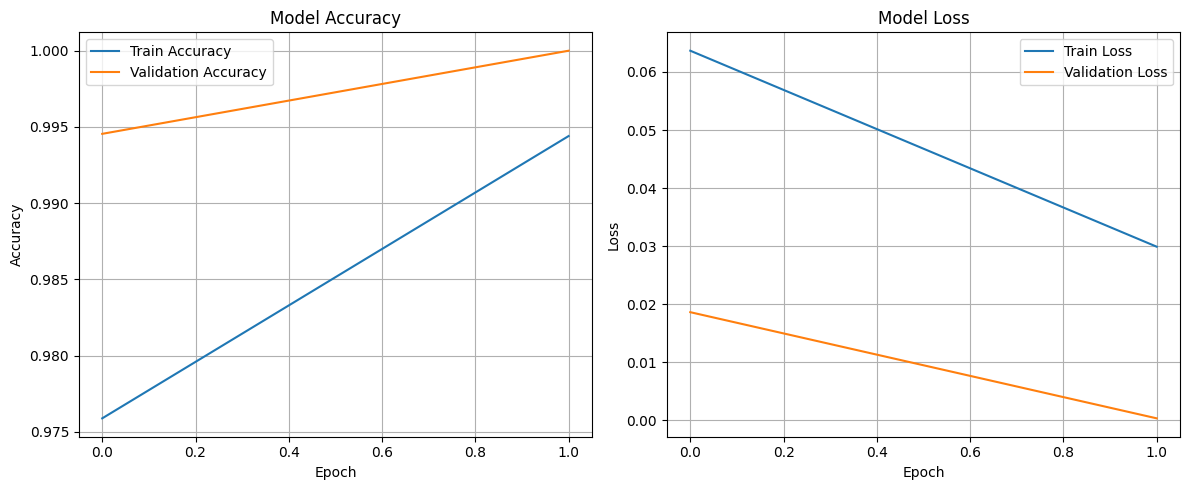

In [7]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loaded_history['accuracy'], label='Train Accuracy')
plt.plot(loaded_history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(loaded_history['loss'], label='Train Loss')
plt.plot(loaded_history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [8]:
# Get training and validation accuracy from history
final_train_acc = loaded_history['accuracy'][-1]
final_val_acc = loaded_history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")


Final Training Accuracy: 0.9944
Final Validation Accuracy: 1.0000


In [9]:
# Print the final accuracy and loss
print("Final Training Accuracy:", loaded_history['accuracy'][-1])
print("Final Validation Accuracy:", loaded_history['val_accuracy'][-1])


Final Training Accuracy: 0.994400143623352
Final Validation Accuracy: 1.0


In [10]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_generator)
print("Training loss:", loaded_history['loss'][-1])
print(f"Validation loss: {val_loss}")


35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 320ms/step - accuracy: 1.0000 - loss: 8.1922e-04
Training loss: 0.02990737184882164
Validation loss: 0.0003484077751636505


In [11]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the binary classifier
model = load_model('retinal_non_retinal_classifier.keras')

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = image / 255.0
    return np.expand_dims(image, axis=0)

def is_retinal_image(image_path):
    image = preprocess_image(image_path)
    prediction = model.predict(image)[0][0]
    return prediction > 0.5  # True = Retinal, False = Non-Retinal

# Example usage
image_path = r"C:\Users\Sameer Ahmad\Desktop\WhatsApp Image 2025-05-04 at 15.31.49_346757a7.jpg"
if is_retinal_image(image_path):
    print("✅ Retinal image detected.")
else:
    print("❌ Not a retinal image.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
❌ Not a retinal image.


In [15]:
import cv2
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import load_model

# Constants
MODEL_PATH = "trained_model.keras"
BINARY_MODEL_PATH = "retinal_non_retinal_classifier.keras"
CLASS_NAMES = ['0_No_DR', '1_Mild', '2_Moderate', '3_Severe', '4_Proliferate_DR']

# Load models once
dr_model = keras.models.load_model(MODEL_PATH)
retinal_check_model = load_model(BINARY_MODEL_PATH)

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = image / 255.0
    return np.expand_dims(image, axis=0)

def is_retinal_image(image_path):
    image = preprocess_image(image_path)
    prediction = retinal_check_model.predict(image)[0][0]
    return prediction > 0.5  # True if retinal

def predict_retinopathy(image_path):
    if not is_retinal_image(image_path):
        return "Invalid Input", 0.0

    processed_image = preprocess_image(image_path)
    prediction = dr_model.predict(processed_image)
    predicted_class = CLASS_NAMES[np.argmax(prediction)]
    confidence = np.max(prediction) * 100
    return predicted_class, confidence

# Example usage
if __name__ == "__main__":
    image_path = r"C:\Users\Sameer Ahmad\Desktop\551_left.jpeg"
    class_name, confidence = predict_retinopathy(image_path)

    if class_name == "Invalid Input":
        print("❌ Error: The uploaded image is not a valid retinal scan.")
    else:
        print(f"✅ Predicted Class: {class_name} (Confidence: {confidence:.2f}%)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
✅ Predicted Class: 2_Moderate (Confidence: 89.88%)
